# 3.8 Sensitivity analysis

In this Notebook we are going to load the Disease model, execute it with different parameter values and test the impact on different parameters in different outputs.

- To load and run the Vensim model we use PySD library, please check the following tutorial before continuing: https://pysd.readthedocs.io/en/master/basic_usage.html#
- Model run's output are Pandas Data Frames, please refer to the Pandas documentation if you need additional insights and supported data operations: https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html#user-guide. 
There is also a 10min tutorial available that might be of your interest: https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
- We implemented the plots using matplotlib, if you need additional information please refer to the following documentation: https://matplotlib.org/stable/contents.html
- For calculating sensitivity indices we used SALib. A basic tutorial can be found here: https://salib.readthedocs.io/en/latest/ 

In [ ]:
# %pip install pysd==3.7.1 -q
# %pip install netCDF4==1.6.1 -q
# %pip install SALib==1.4.5 -q
# %pip install pysd

In [1]:
import warnings
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysd 
from SALib.sample import saltelli
from SALib.analyze import sobol

In [2]:
# load the model using PySD
# make sure the model file is in the same folder as the notebook
model = pysd.read_vensim(r'SFD_Group.mdl')

In [3]:
# run the model
model_output = model.run()
model_output.head(5)

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,Scaled divorce,Marriage rate,Delay for societal,Divorce,Societal factor,Population,...,Economic factor,Unmarried,K,Marriage,Married,Recovery rate,Divorce rate,Education,W eco,W soc
1992.00,2018,1992,0.25,0.25,340.500009,0.123413,3,6.308103e+07,0.588623,185260000.0,...,0.53333,4.179500e+07,2.2,5.158054e+06,1.132950e+08,0.004,0.556786,0.9,0.649,0.338
1992.25,2018,1992,0.25,0.25,296.979169,0.123413,3,5.501836e+07,0.588623,185260000.0,...,0.53333,4.053566e+07,2.2,5.002634e+06,9.881426e+07,0.004,0.556786,0.9,0.649,0.338
1992.50,2018,1992,0.25,0.25,259.399497,0.123413,3,4.805635e+07,0.588623,185260000.0,...,0.53333,3.931517e+07,2.2,4.852010e+06,8.631032e+07,0.004,0.556786,0.9,0.649,0.338
1992.75,2018,1992,0.25,0.25,226.937609,0.123413,3,4.204246e+07,0.588623,185260000.0,...,0.53333,3.813365e+07,2.2,4.706194e+06,7.550924e+07,0.004,0.556786,0.9,0.649,0.338
1993.00,2018,1992,0.25,0.25,198.968492,0.123205,3,3.686090e+07,0.589316,185260000.0,...,0.53333,3.699093e+07,2.2,4.557469e+06,6.617517e+07,0.004,0.557020,0.9,0.649,0.338


In [17]:
# list variables and parameters in the model
list(model_output)

['FINAL TIME',
 'INITIAL TIME',
 'SAVEPER',
 'TIME STEP',
 'Marriage rate',
 'Delay for societal',
 'Divorce',
 'Societal factor',
 'Population',
 'Delay for recovery',
 'Recovery',
 'Divorced',
 'Economic factor',
 'Unmarried',
 'K',
 'Marriage',
 'Married',
 'Recovery rate',
 'Divorce rate',
 'Education',
 'W eco',
 'W soc']

## Calculation of sensitivity indices

In [46]:
# load the model using PySD
# make sure the model file is in the same folder as the notebook
model = pysd.read_vensim(r'SFD_Group.mdl')

In [4]:
observable = 'Divorce'
parameter1 = 'W eco'
parameter2 = 'W soc'
parameter3 = 'K'
parameter4 = 'Recovery rate'
parameter5 =  'Delay for societal'
timetoobserve = 2018


parameter1_vals = []
parameter2_vals = []
parameter3_vals = []
parameter4_vals = []
parameter5_vals = []
observable_vals = []

# loop over different values of total W eco
for param1_val in np.arange(0., 1.0, 0.1):

    # loop over different values of W soc
    for param2_val in np.arange(0., 1-param1_val+0.1, 0.1):

        # loop over different values of K
            for param3_val in np.arange(-5., 10.8, 0.8):
                
                # loop over different values of Recovery rate
                for param4_val in np.arange(0., 1.1, 0.1):
                    
                    # loop over different values of delay of societal
                    for param5_val in np.arange(0., 20, 1):

                        # multiple repetitions for each parameter combination
                        for i in np.arange(0, 1, 1):

                            # run the model with the current parameter combination
                            # the following two lines hide warnings which we don't want to see
                            with warnings.catch_warnings():
                                warnings.filterwarnings('ignore')
                                result = model.run(params={parameter1: param1_val,
                                                        parameter2: param2_val,
                                                        parameter3: param3_val,
                                                        parameter4: param4_val,
                                                        parameter5:param5_val},
                                                return_timestamps=[timetoobserve],
                                                return_columns=[observable,'Population'])

                            # store results
                            parameter1_vals.append(param1_val)
                            parameter2_vals.append(param2_val)
                            parameter3_vals.append(param3_val)
                            parameter4_vals.append(param4_val)
                            parameter5_vals.append(param5_val)
                            observable_vals.append(result.loc[timetoobserve, observable])

# collect results into a DataFrame
output = pd.DataFrame({parameter1: parameter1_vals,
                       parameter2: parameter2_vals,
                       parameter3: parameter3_vals,
                       parameter4: parameter4_vals,
                       parameter5: parameter5_vals,
                       observable: observable_vals})

In [6]:
# variance of the observable across all parameter combinations
observable_var = output.var(ddof=0)[observable]
print(f'Total variance on day 10 in {observable}: {observable_var:.4f}')

# sensitivity index for parameter 1
param1_ind = output.groupby(parameter1).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter1} on day 10 is {param1_ind:.4f}')

# sensitivity index for parameter 2
param2_ind = output.groupby(parameter2).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter2} on day 10 is {param2_ind:.4f}')


# sensitivity index for parameter 3
param3_ind = output.groupby(parameter3).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter3} on day 10 is {param3_ind:.4f}')

# sensitivity index for parameter 4
param4_ind = output.groupby(parameter4).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter4} on day 10 is {param4_ind:.4f}')

# sensitivity index for parameter 5
param5_ind = output.groupby(parameter5).mean().var(ddof=0)[observable]/observable_var
print(f'An estimate of the first-order sensitivity index of {parameter5} on day 10 is {param5_ind:.4f}')

Total variance on day 10 in Divorce: 40518413043369.0234
An estimate of the first-order sensitivity index of W eco on day 10 is 0.0003
An estimate of the first-order sensitivity index of W soc on day 10 is 0.0029
An estimate of the first-order sensitivity index of K on day 10 is 0.2324
An estimate of the first-order sensitivity index of Recovery rate on day 10 is 0.7090
An estimate of the first-order sensitivity index of Delay for societal on day 10 is 0.0002


## Calculation of sensitivity indices using SALib

In [14]:
# define problem for determining the sensitivity indices using SALib
problem = {
    'num_vars': 5,
    'names': ['W eco', 'W soc','K','Recovery rate', 'Delay for societal'], #,'Maximum'
    'bounds': [[0, 1],
               [0, 1],
               [-5, 10],
               [0, 1],
               [0.5, 20]]
}

# calculate sample points used for sensitivity analysis
param_values = saltelli.sample(problem, 128, calc_second_order=False)

# Ensure the sum of 'W eco' and 'W soc' does not exceed 1
for i in range(param_values.shape[0]):
    param_values[i, 0] = min(param_values[i, 0], 1 - param_values[i, 1])

In [15]:
# array for observable values
Y = np.zeros([param_values.shape[0]])
timetoobserve = 2018

# loop through all parameter combinations in the sample
for i, X in enumerate(param_values):
    param1_val, param2_val, param3_val, param4_val, param5_val = X

    # store observable value at this parameter combination
    # again, we want to ignore warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        Y[i] = model.run(params={parameter1: param1_val, parameter2: param2_val,
                                parameter3: param3_val, parameter4: param4_val,
                                parameter5: param5_val},
                         return_timestamps=[timetoobserve],
                         return_columns=[observable]).loc[timetoobserve, observable]


In [16]:
# perform calculation of sensitivity indices
Si = sobol.analyze(problem, Y, calc_second_order=False, print_to_console=True)

                          ST   ST_conf
W eco               0.003195  0.001570
W soc               0.013437  0.007333
K                   0.282145  0.076146
Recovery rate       0.697511  0.169429
Delay for societal  0.017451  0.011681
                          S1   S1_conf
W eco               0.002683  0.014104
W soc               0.030359  0.035811
K                   0.304157  0.121289
Recovery rate       0.588671  0.240298
Delay for societal -0.002908  0.039763


array([<Axes: >, <Axes: >], dtype=object)

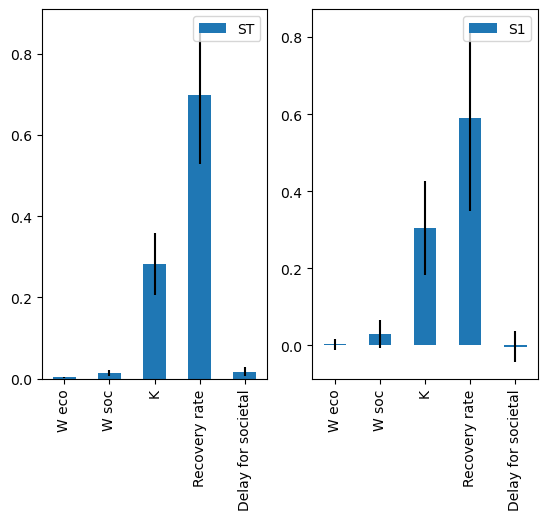

In [17]:
Si.plot()